In [82]:
import os

import gzip
import numpy as np
import pandas as pd
import prince

import json
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import gensim.downloader as api

from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
import spacy

from spacy.lang.en import English

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield json.loads(l)

In [3]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [4]:
# rent_runway = pd.DataFrame(list(readGz("./renttherunway_final_data.json.gz")))

In [5]:
# # Data Cleaning Cell
# rent_runway["bust size"] = rent_runway["bust size"].str[2:]
# rent_runway["weight"] = rent_runway["weight"].str[:-3].astype(float)
# rent_runway["height"] = (rent_runway["height"].str[0].astype(float) * 12) + rent_runway["height"].str[2:-1].astype(float)
# rent_runway["age"] = rent_runway["age"].astype(float)
# rent_runway["rating"] = rent_runway["rating"].astype(float)
# rent_runway["review_date"] = pd.to_datetime(rent_runway["review_date"])
# rent_runway["year"] = rent_runway["review_date"].dt.year
# rent_runway["month"] = rent_runway["review_date"].dt.month
# rent_runway.loc[rent_runway["rented for"] == "party: cocktail", "rented for"] = "other"
# rent_runway = rent_runway.drop(columns="review_date")
# filtered_runway = rent_runway.dropna()
fp = os.path.join(os.path.dirname(os.path.realpath('eda.ipynb')) + '/cleaned_runway.csv')
runway = pd.read_csv(fp).dropna()

# EDA

- Turn `category` columns into values that inform the `rented for` column
    - If an item is not largely associated with a particular category, label it as "general" or "other"
- Look for correlated features and point them out
- If you have time, perform DSC80 style permutation tests with the TVD test stat to get pvalues that represent if a correlation exists with the `rented for` column
    - These would include the following columns: \['fit', 'body type', 'age', 'year', 'month'\]
- Any extra stuff would be sick

# Model Dev

In [10]:
X = runway.drop(columns=["rented for","user_id","item_id"])
X["age"] = pd.qcut(X["age"],q=10).astype(str)
y = runway["rented for"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=75)

In [27]:
# From EDA we will have our category to occasion map
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Perform arbitary trans
        def temp(x):
            ret_val = pd.Series(self.model.encode(x.values).tolist())
            return ret_val
        X = pd.DataFrame(X)
        X = X.apply(temp)
        X = np.array(X[X.columns].values.tolist())
        return np.hstack([X[:, i] for i in range(X.shape[1])])

In [13]:
# Baseline model
categories = ['other','vacation', 'formal', 'wedding', 'date', 'everyday', 'party', 'work']
preds = pd.DataFrame(columns=categories)
for category in categories[1:]:
    preds[category] = runway["review_text"].str.count(category)
preds = preds.fillna(0)
preds = preds.T.idxmax()
preds = preds.str.replace('formal',"formal affair")

In [14]:
balanced_accuracy_score(y,preds)

0.26419133400787553

## Real Model Dev

In [72]:
sizes = ['a', 'aa', 'b', 'c', 'd', 'd+', 'dd', 'ddd/e', 'f', 'g', 'h', 'i', 'j']
one_hot_vars = ['fit', 'body type', 'age', 'year', 'month']
numerical_cols = ["weight","height","size","rating"]
preper = ColumnTransformer([
    ("one-hot",OneHotEncoder(), one_hot_vars),
    ("ordinal", OrdinalEncoder(categories=[sizes]), ['bust size']),
    ("category", Word2VecTransformer(), ["review_text",'category']),
    ("identity", FunctionTransformer(), numerical_cols)
])
pipe = Pipeline([
    ("preproc", preper),
    ("standard", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000))
])

In [73]:
X_sample = X_train.iloc[:50]
y_sample = y_train.iloc[:50]

In [74]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('one-hot', OneHotEncoder(),
                                                  ['fit', 'body type', 'age',
                                                   'year', 'month']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['a',
                                                                              'aa',
                                                                              'b',
                                                                              'c',
                                                                              'd',
                                                                              'd+',
                                                                              'dd',
                                                                              'ddd/e',
              

In [75]:
y_preds = pipe.predict(X_test)

In [76]:
balanced_accuracy_score(y_test,y_preds)

0.417692262214154

In [ ]:
# 0.458230862317992 Using GLoVE
# 0.5487018065222492 Using BERT and Sentence Embedding
# BA
# -inf Using BERT and PEESHEEAHY

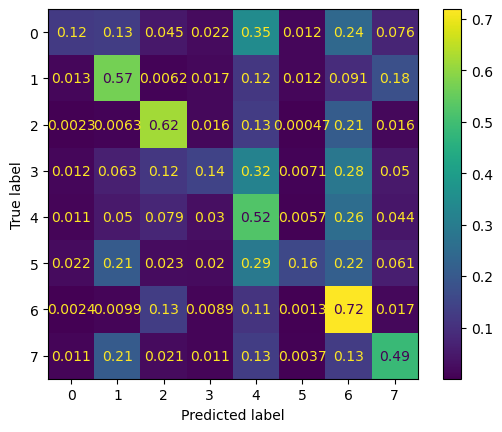

In [85]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_preds, normalize="true"))
disp.plot()
plt.show()

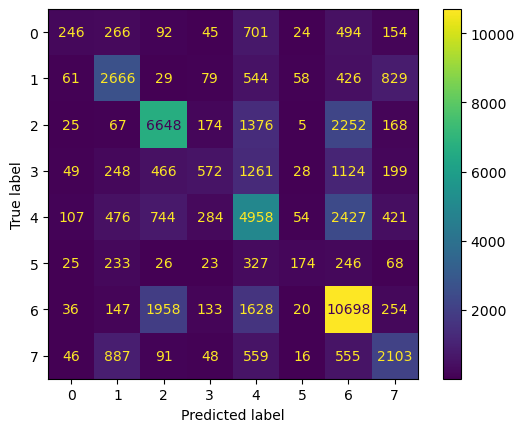

In [111]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_preds))
disp.plot()
plt.show()

In [106]:
pd.Series(y_preds).loc[(y_test == y_preds).values].value_counts()

wedding          10698
formal affair     6648
party             4958
everyday          2666
work              2103
other              572
date               246
vacation           174
dtype: int64

In [110]:
y_test.value_counts(normalize=True)

wedding          0.290803
formal affair    0.209490
party            0.185169
everyday         0.091734
work             0.084168
other            0.077168
date             0.039532
vacation         0.021936
Name: rented for, dtype: float64